In [1]:
import os
import ast
import textwrap
import tiktoken
import keyboard
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from typing import Optional

In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)

# Eliminar la primera página o portada del doc.

In [3]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./docs/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [4]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

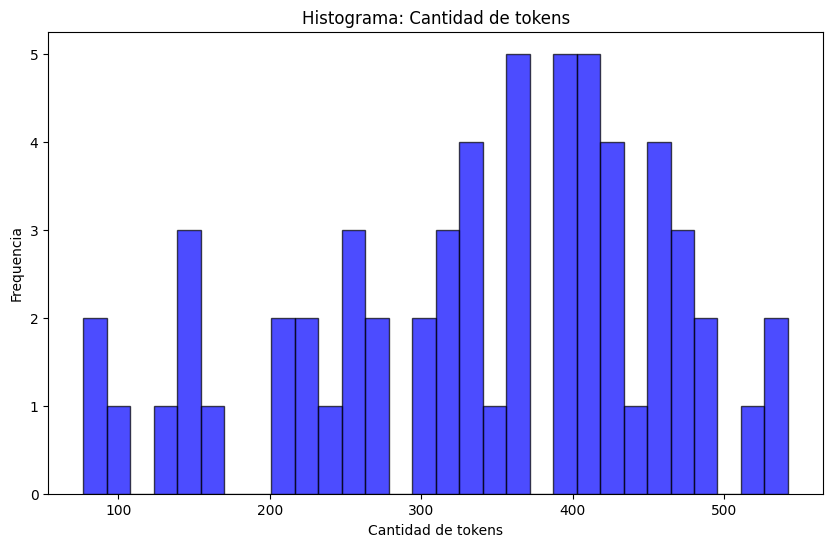

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.show()

In [6]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 20539


# 1. ¿Incrustar de cero?
# 2. ¿Elegir un encrustamiento guardado?

In [7]:
user_input = input("Elige 1 o 2: ")

if user_input.lower() == "1":
    print('Elegiste 1')
    global_embeddings = [embeddings.embed_query(txt) for txt in texts]

    embed_name = input('¿Cómo se llama esta incrustación?: ') + '_emb' + '.txt'
    with open(rf'./embed/{embed_name}', 'w') as f:
        for i in global_embeddings:
            f.write("%s\n" % i)
    
elif user_input.lower() == "2":
    print('Elegiste 2')
    global_embeddings = []

    embed_name = input('Nombre del encrustamiento: ') + '_emb' + '.txt'

    with open(rf'./embed/{embed_name}', 'r') as f:
        for i in f:
            x = ast.literal_eval(i.strip())  # Convertir la cadena a lista de números
            global_embeddings.append(x)

    global_embeddings = np.array(global_embeddings, dtype=float)
    
elif user_input != "1" and user_input != "2":
    print("No seleccionaste ningún encrustamiento.")

Elegiste 1


In [8]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

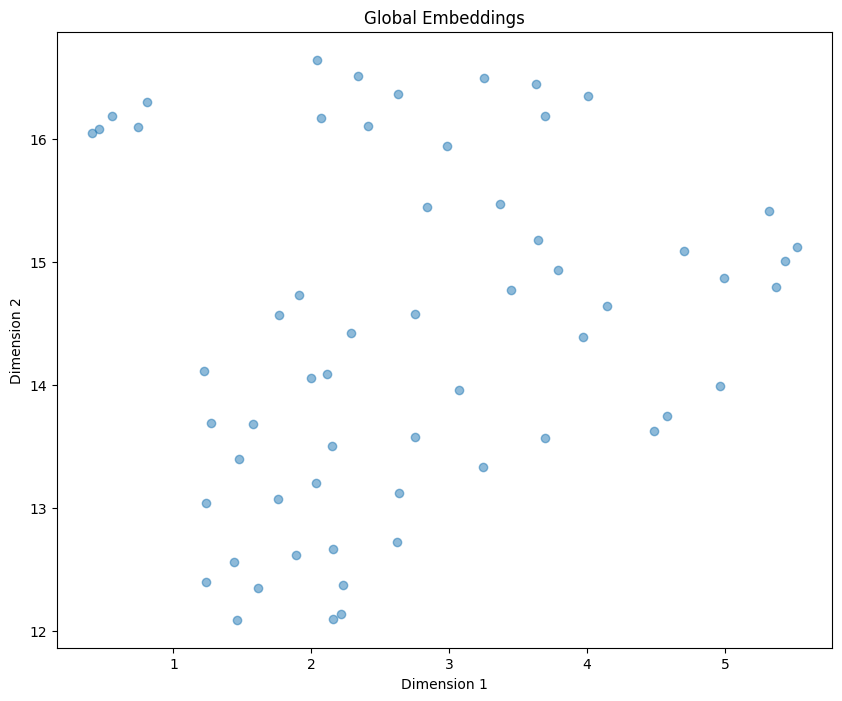

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


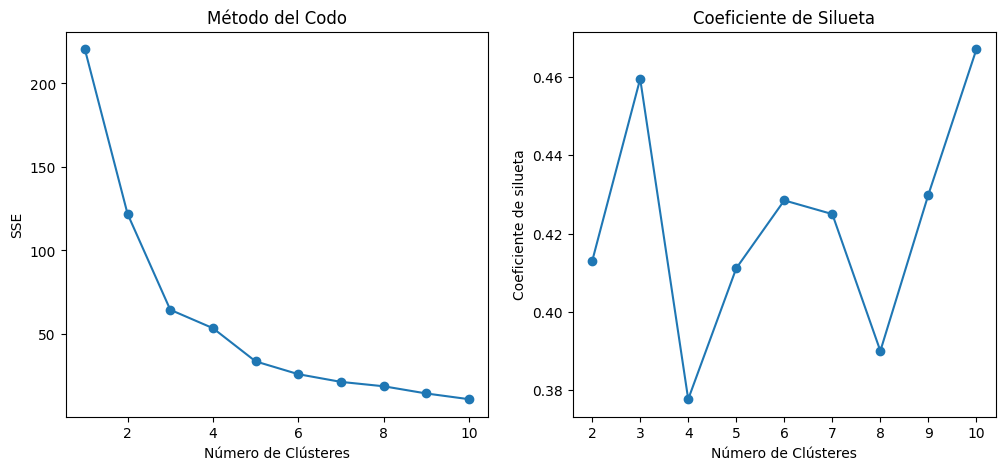

Número óptimo de clústeres según el método del codo: 1
Número óptimo de clústeres según el coeficiente de silueta: 10


In [10]:
# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Coeficiente de silueta')
plt.show()

# Determinación del número óptimo de clústeres
optimal_k_elbow = np.argmin(np.diff(sse)) + 1  # Codo
optimal_k_silhouette = k_values[1:][np.argmax(silhouette_scores)]  # Silueta

print(f"Número óptimo de clústeres según el método del codo: {optimal_k_elbow}")
print(f"Número óptimo de clústeres según el coeficiente de silueta: {optimal_k_silhouette}")

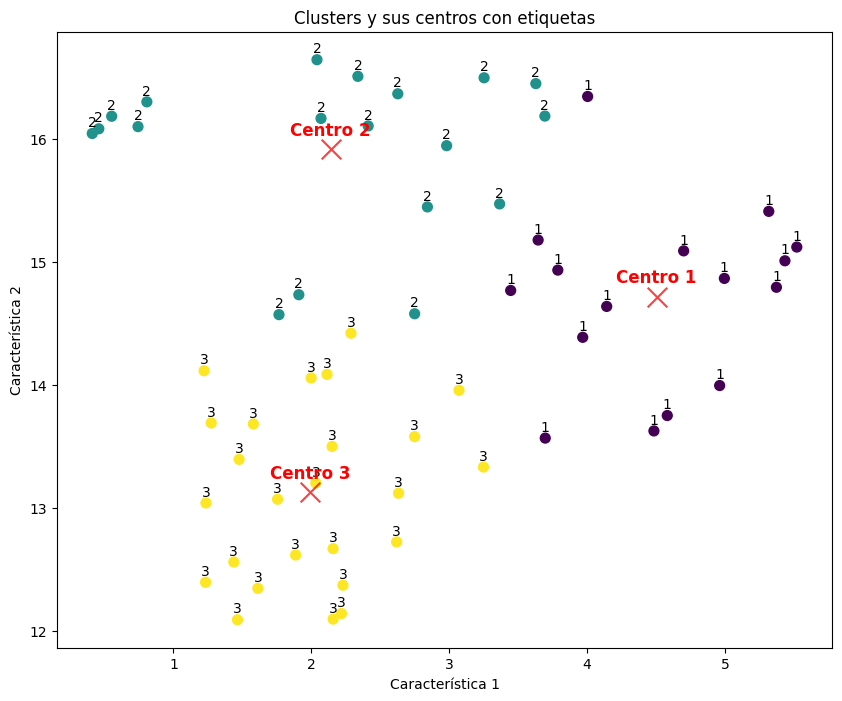

In [11]:
# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = input('¿Cuántos clústeres quiere usar?: ')

kmeans = KMeans(n_clusters=int(optimal_k), random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus centros con etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

# Aplicar análisis a base de datos para determinar de qué habla (tema principal) cada clúster.

In [12]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()
doc_nom = input('Ingrese el nombre del documento')
df.to_csv(f'{doc_nom}.csv', sep=';', encoding='utf-8-sig')

In [13]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{2: 'Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   1       Impacto de la innovación de producto, innovación de proceso, innovación  organizacional y la percepción de la corrupción, en la rentabilidad empresarial en  Colombia       Gueiriluz Romero Chaparro   Juan Felipe Gó mez Quiceno       Universidad EAN   Facultad de Administración   Maestría en administración de empresas   Bogotá  D.C, Colombia    Julio  de 2022 --- Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   2     Implicaciones de la innovación empresarial  en Colombia   Juan Felipe Gómez Quiceno   Gueiriluz Romero Chaparro     Trabajo de grado presentado como  requisito para optar al título de:   Magister en administración de empresas   Director :  Juan Manuel Gil Barragán     Modalidad: 

In [14]:
template = """Eres un asistente capaz de crear resúmenes extremadamente detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [15]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{2: 'El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema abordado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno de la Universidad EAN. El propósito de la investigación es analizar cómo estas variables afectan la rentabilidad de las empresas en Colombia.\n\nEl estudio se enfoca en identificar el impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de corrupción en la rentabilidad empresarial en Colombia. Los objetivos específicos incluyen analizar el impacto de la innovación de producto, evaluar el impacto de la innovación de proceso, dar cuenta del impacto de la innovación organizacional y comprender la percepción de corrupción en la innovación empresarial en Colombia.\n\nSe utilizó un enfoque de investigación cuantitativa para abordar la pregunta de investigación sobre el impac

In [16]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{2: ['El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema abordado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno de la Universidad EAN. El propósito de la investigación es analizar cómo estas variables afectan la rentabilidad de las empresas en Colombia.\n\nEl estudio se enfoca en identificar el impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de corrupción en la rentabilidad empresarial en Colombia. Los objetivos específicos incluyen analizar el impacto de la innovación de producto, evaluar el impacto de la innovación de proceso, dar cuenta del impacto de la innovación organizacional y comprender la percepción de corrupción en la innovación empresarial en Colombia.\n\nSe utilizó un enfoque de investigación cuantitativa para abordar la pregunta de investigación sobre el impa

In [17]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{2: 'El estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno de la Universidad EAN analiza el impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de corrupción en la rentabilidad empresarial en Colombia. Se observó que la percepción de corrupción no necesariamente se traduce en corrupción real que afecte significativamente la rentabilidad de las empresas. La innovación de procesos, productos y organizacional se identificó como aspectos relevantes para mejorar la eficiencia, calidad y competitividad de las empresas. Se concluyó que la innovación es fundamental para el crecimiento y éxito de las empresas en un entorno competitivo y globalizado. El estudio encontró que la innovación de procesos y organizacional impacta positivamente en la rentabilidad empresarial, mientras que la percepción de corrupción no mostró una correlación significativa con la rentabilidad.'}

In [18]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [19]:
combined_texts[:10]

['Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   1       Impacto de la innovación de producto, innovación de proceso, innovación  organizacional y la percepción de la corrupción, en la rentabilidad empresarial en  Colombia       Gueiriluz Romero Chaparro   Juan Felipe Gó mez Quiceno       Universidad EAN   Facultad de Administración   Maestría en administración de empresas   Bogotá  D.C, Colombia    Julio  de 2022',
 'Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   2     Implicaciones de la innovación empresarial  en Colombia   Juan Felipe Gómez Quiceno   Gueiriluz Romero Chaparro     Trabajo de grado presentado como  requisito para optar al título de:   Magister en administración de empresas   Director :  Juan Manuel Gil Barragán     Modalidad:   M

In [20]:
# Nombre del archivo de texto
file_name = "final_test.txt"

# Escribir la lista en el archivo de texto
with open(file_name, 'w', encoding='utf-8') as f:
    for t in combined_texts:
        f.write("%s\n" % t)

# Leer el contenido del archivo y mostrarlo
with open(file_name, 'r', encoding='utf-8') as f:
    content = f.read()

textos = text_splitter.split_text(content)

# Guardar los kb en una carpeta (kbs)

### 1. Enseñar

In [21]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=textos,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [22]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

17


In [23]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas específicas. Evita concluir tus respuestas con un 
párrafo que comience con 'En resumen,...'. Varía las conclusiones de tus respuestas para que 
sean más diversas y creativas.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables específicamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusión predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [24]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"][:5]:
        print(contexto)

In [25]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuál es la metodología usada en la investigación?
La metodología utilizada en la investigación es de enfoque
cuantitativo, específicamente un enfoque analítico. Este tipo de
enfoque busca descubrir una posible relación causal entre distintos
fenómenos naturales, en este caso, entre la innovación de producto,
innovación de proceso, innovación organizacional y la percepción de
corrupción, y su impacto en la rentabilidad empresarial en Colombia.
Se recolectaron datos a través de la revisión de la base de datos del
Banco Mundial y se aplicó un análisis de correlación de Pearson para
una regresión lineal múltiple. Se utilizó un nivel de confianza del
95% y se realizaron pruebas estadísticas como ANOVA y Prueba T para
validar las hipótesis planteadas en la investigación. Todo esto con el
fin de obtener conclusiones significativas acerca de la relación entre
las variables estudiadas y su influencia en la rentabilidad de las
empresas.

Referencias:
page_content='prueban  estadísticamente ”.  

# Hacer historial